In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

In [11]:
# Set seaborn style for better visuals
sns.set(style="whitegrid")

# ----------------------------
# Data Loading & Preprocessing
# ----------------------------
df = pd.read_csv("bank_preprocessed.csv")

# Split features and target
X = df.drop(columns=['y']).values
y = df['y'].values

# Convert labels from {0,1} to {-1, +1} for SVM
y = 2 * y - 1

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-validation split (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)

In [12]:
# ----------------------------
# Define the SVM Model
# ----------------------------
class SVM(nn.Module):
    def __init__(self, input_dim):
        super(SVM, self).__init__()
        self.linear = nn.Linear(input_dim, 1)  # Simple linear classifier

    def forward(self, x):
        return self.linear(x)

# Initialize model
model = SVM(X_train.shape[1]).to(device)

In [13]:
# ----------------------------
# Define the Hinge Loss Function
# ----------------------------
def hinge_loss(outputs, targets):
    # Hinge loss: max(0, 1 - y*(Wx+b))
    return torch.mean(F.relu(1 - targets * outputs))

In [14]:
# ----------------------------
# Training Setup
# ----------------------------
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)
epochs = 100

train_losses = []
val_losses = []
val_accuracies = []

/home/varnit/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [15]:
# ----------------------------
# Training Loop
# ----------------------------
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = hinge_loss(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = hinge_loss(val_outputs, y_val_tensor)
        val_losses.append(val_loss.item())
        
        # Get predictions (using sign)
        val_preds = torch.sign(val_outputs)
        correct = (val_preds == y_val_tensor).sum().item()
        accuracy = correct / y_val_tensor.size(0)
        val_accuracies.append(accuracy)
    
    scheduler.step(val_loss)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs} - Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Acc: {accuracy:.4f}")

Epoch 0/100 - Train Loss: 1.0074, Val Loss: 0.9842, Val Acc: 0.5395
Epoch 10/100 - Train Loss: 0.7928, Val Loss: 0.7826, Val Acc: 0.6708
Epoch 20/100 - Train Loss: 0.6580, Val Loss: 0.6470, Val Acc: 0.7965
Epoch 30/100 - Train Loss: 0.5506, Val Loss: 0.5389, Val Acc: 0.8295
Epoch 40/100 - Train Loss: 0.4608, Val Loss: 0.4522, Val Acc: 0.8597
Epoch 50/100 - Train Loss: 0.3913, Val Loss: 0.3863, Val Acc: 0.8841
Epoch 60/100 - Train Loss: 0.3452, Val Loss: 0.3424, Val Acc: 0.8875
Epoch 70/100 - Train Loss: 0.3105, Val Loss: 0.3098, Val Acc: 0.8893
Epoch 80/100 - Train Loss: 0.2796, Val Loss: 0.2806, Val Acc: 0.8895
Epoch 90/100 - Train Loss: 0.2566, Val Loss: 0.2599, Val Acc: 0.8911


In [16]:
# ----------------------------
# Final Evaluation
# ----------------------------
model.eval()
with torch.no_grad():
    final_outputs = model(X_val_tensor)
    final_preds = torch.sign(final_outputs)

# Convert predictions from {-1, +1} to {0,1} for evaluation
final_preds_np = ((final_preds.cpu().numpy().flatten() + 1) // 2).astype(int)
y_val_np = ((y_val_tensor.cpu().numpy().flatten() + 1) // 2).astype(int)

final_accuracy = (final_preds_np == y_val_np).mean()
print(f"\nFinal PyTorch SVM Accuracy: {final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_val_np, final_preds_np))


Final PyTorch SVM Accuracy: 0.8938

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      7952
           1       0.61      0.33      0.43      1091

    accuracy                           0.89      9043
   macro avg       0.76      0.65      0.69      9043
weighted avg       0.88      0.89      0.88      9043



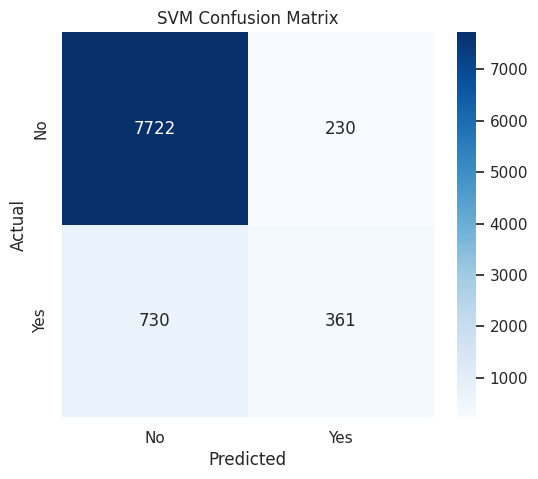

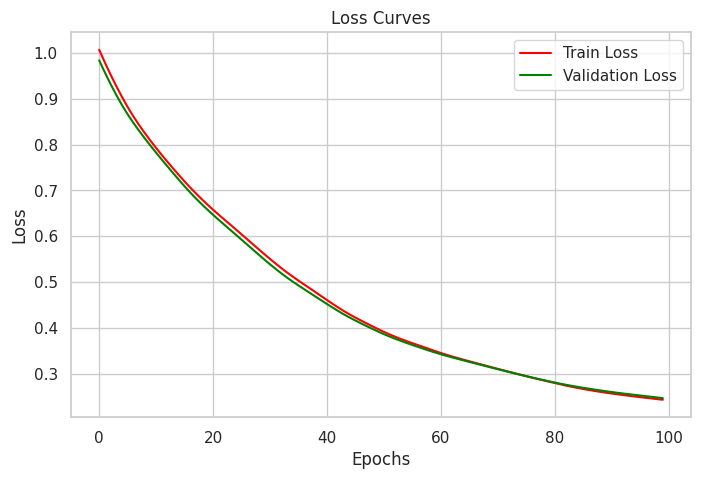

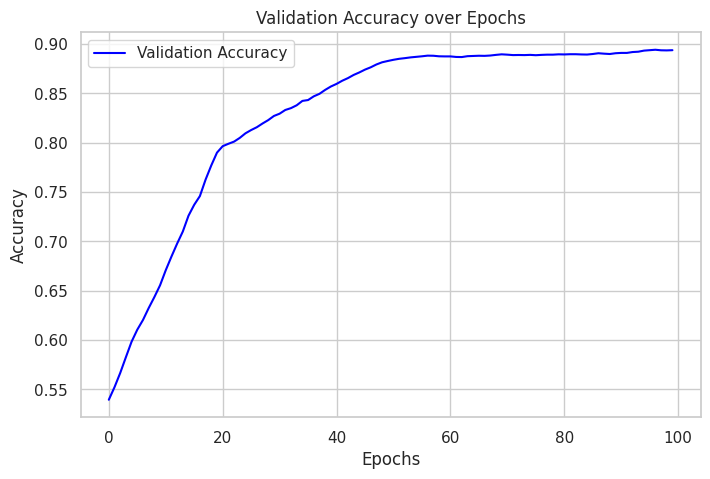

In [17]:
# ----------------------------
# Plotting Results
# ----------------------------
# Confusion Matrix
conf_matrix = confusion_matrix(y_val_np, final_preds_np)
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Loss Curves (Train & Validation)
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss", color="red")
plt.plot(val_losses, label="Validation Loss", color="green")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.show()

# Validation Accuracy Curve
plt.figure(figsize=(8,5))
plt.plot(val_accuracies, label="Validation Accuracy", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.legend()
plt.show()
